## Import Libraries

In [2]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN

from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

%matplotlib inline

## Load the Data

In [3]:
df=pd.read_csv("final_data.csv")

In [4]:
df.shape

(10754, 22)

In [5]:
df.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [6]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [7]:
# Completeness
df.isnull().sum()

player                 0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [8]:
# Accurecy types
df.dtypes

player                  object
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [9]:
categorical_features = ['team', 'position', 'position_encoded', 'winger']
numeric_features = ['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded',
                    'clean sheets', 'minutes played', 'days_injured', 'games_injured', 'award', 'current_value', 'highest_value']

In [10]:
for i in categorical_features:
    print (df[i].value_counts())

team
Daejeon Hana Citizen      46
Jeonbuk Hyundai Motors    46
FC Seoul                  45
Gangwon FC                43
Daegu FC                  42
                          ..
FC Barcelona              22
Atlético de Madrid        22
CA Osasuna                22
Hatayspor                 12
Gaziantep FK               6
Name: count, Length: 374, dtype: int64
position
Defender Centre-Back          1821
Attack Centre-Forward         1353
Goalkeeper                    1229
midfield-CentralMidfield      1149
midfield-DefensiveMidfield     900
Defender Right-Back            867
Defender Left-Back             807
midfield-AttackingMidfield     769
Attack-RightWinger             717
Attack-LeftWinger              714
midfield-RightMidfield         102
midfield-LeftMidfield          100
midfield                        75
Attack-SecondStriker            65
Attack                          53
Defender                        33
Name: count, dtype: int64
position_encoded
2    3528
3    3095
4    

In [11]:
df=df[(df['current_value'] <= 100000000) & (df['current_value'] > 0)]

In [12]:
df=df[(df['minutes played'] <= 6000) & (df['minutes played'] > 0)]

In [13]:
df=df[(df['appearance'] <= 80) & (df['appearance'] > 0)]

In [14]:
df=df[(df['highest_value'] <= 20000000) & (df['highest_value'] > 0)]

In [15]:
df.drop(columns=['player'], inplace=True)

In [16]:
df=df[(df['age'] <= 35) & (df['age'] > 15)]

In [17]:
df=df[(df['games_injured'] < 20)]

In [18]:
df=df[(df['days_injured'] < 250)]

In [19]:
df.shape

(6342, 21)

In [20]:
df['current_value'].describe()

count    6.342000e+03
mean     1.585142e+06
std      2.662076e+06
min      1.000000e+04
25%      2.500000e+05
50%      6.000000e+05
75%      1.700000e+06
max      2.000000e+07
Name: current_value, dtype: float64

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [21]:
df.head(2)

,team,name,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
8,Manchester United,Teden Mengi,Defender Centre-Back,186.0,21.0,34,0.000000,0.000000,0.130529,0.0,...,0.0,0.0,2758,47,13,0,2000000,2000000,2,0
20,Manchester United,Zidane Iqbal,midfield-CentralMidfield,181.0,20.0,39,0.129125,0.064562,0.225968,0.0,...,0.0,0.0,2788,0,0,1,800000,800000,3,0


In [22]:
q25 = df["current_value"].quantile(0.25)
q75 = df["current_value"].quantile(0.75)

In [23]:
q25, q75

(250000.0, 1700000.0)

In [24]:

# Function to categorize prices
def categorize_price(value):
    if value < q25:
        return 'Low_Value'
    elif value < q75:
        return 'Mid_Value'
    else:
        return 'High_Value'

# Apply the function to create a new column
df['current_value_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['current_value_category'].value_counts())

current_value_category
Mid_Value     3255
High_Value    1598
Low_Value     1489
Name: count, dtype: int64


In [25]:
#pd.set_option('display.max_rows', None)

In [26]:
encoder = LabelEncoder()
df['current_value_category_encoded'] = encoder.fit_transform(df['current_value_category'])  

In [27]:
df['current_value_category_encoded'].value_counts()

current_value_category_encoded
2    3255
0    1598
1    1489
Name: count, dtype: int64

#### 3. Feature selection

In [28]:
#df.drop('name', axis=1, inplace=True)

In [29]:
#sns.heatmap(df.corr(), annot=True);

In [30]:
correlation = df.corr(numeric_only=True)
#print(correlation['Price'].sort_values(ascending=False))
print(correlation['current_value_category_encoded'].sort_values(ascending=False))

current_value_category_encoded    1.000000
age                               0.155252
winger                            0.021776
goals conceded                    0.020119
red cards                         0.013908
yellow cards                      0.010895
clean sheets                      0.009063
second yellow cards               0.006656
height                           -0.031553
position_encoded                 -0.044292
goals                            -0.047326
assists                          -0.050833
days_injured                     -0.062405
award                            -0.072510
games_injured                    -0.077732
minutes played                   -0.141447
appearance                       -0.152717
highest_value                    -0.532911
Name: current_value_category_encoded, dtype: float64


In [31]:
# Set the correlation threshold
threshold = 0.1  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value_category_encoded']) > \
threshold]['current_value_category_encoded'].index
selected_features

Index(['age', 'appearance', 'minutes played', 'highest_value',
       'current_value_category_encoded'],
      dtype='object')

In [32]:
selected_features = [ 'appearance', 'minutes played', 'highest_value']

In [33]:
df = df[selected_features]
df.head()

,appearance,minutes played,highest_value
8,34,2758,2000000
20,39,2788,800000
21,51,3512,800000
28,34,1030,7000000
32,41,3606,17500000


#### 4. Prepare train and test data

In [34]:
#Prepare data
X = df


# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
X.shape

(6342, 3)

## Buliding the Model

In [36]:
# 2. Use NearestNeighbors to find the optimal eps
min_samples = 5

In [37]:
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

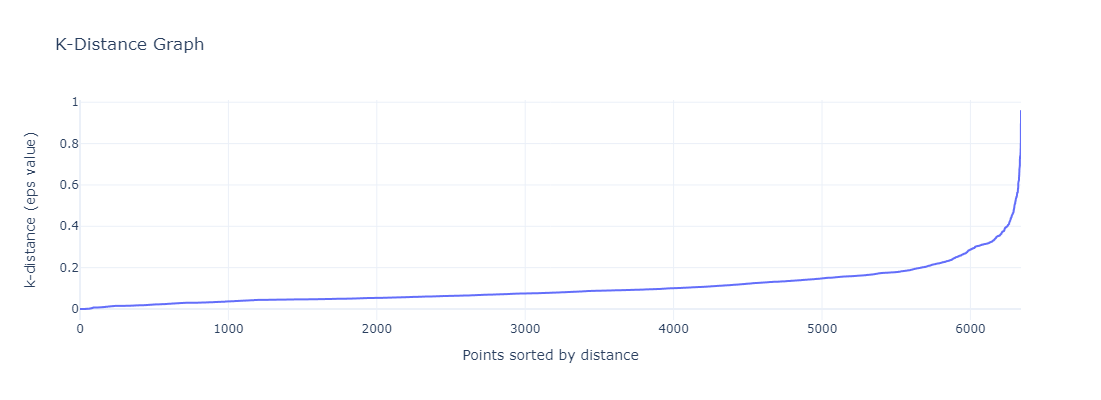

In [44]:
import numpy as np
import plotly.express as px

# The distance to the furthest neighbor (min_samples-th nearest) for each point
k_dist = distances[:, min_samples-1]

# Sort distances
k_dist_sorted = np.sort(k_dist)

# Creating the k-distance graph using Plotly
fig = px.line(
    x=np.arange(len(k_dist_sorted)),
    y=k_dist_sorted,
    title='K-Distance Graph',
    labels={'x': 'Points sorted by distance', 'y': 'k-distance (eps value)'},
    template='plotly_white'
)
fig.update_layout(
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    height=400,
    width=600
)
fig.show()


In [45]:
chosen_eps = 0.40  # This is an example; choose this value based on the plot
dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples)

## Train the Model

In [46]:
clusters = dbscan.fit_predict(X_scaled)

In [47]:
pd.Series(clusters).value_counts()


 0    6238
-1      47
 3      25
 1      13
 2       7
 4       7
 5       5
Name: count, dtype: int64

## Evaluating the Model 

In [48]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X, clusters)
silhouette_avg

0.6876446007010768

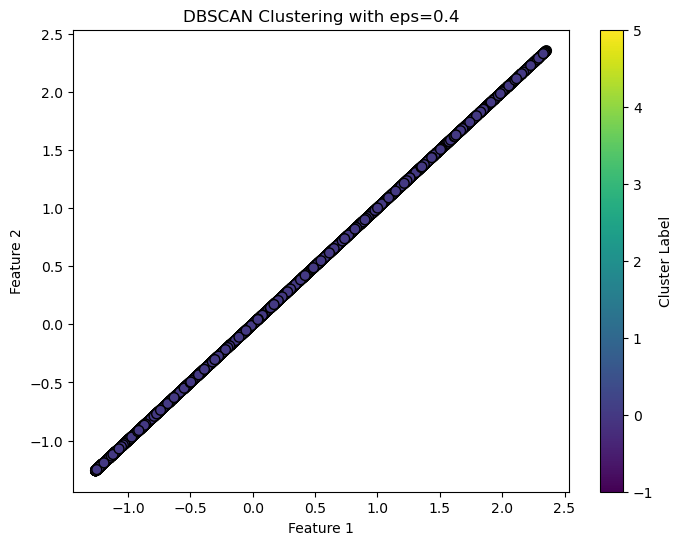

In [54]:

# 5. Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:,1], X_scaled[:, 1], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title(f'DBSCAN Clustering with eps={chosen_eps}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()